In [1]:
import gymnasium
import numpy as np
from gymnasium import spaces
import matplotlib.pyplot as plt
from utils import visualise_pricing_strategy, visualise_episode_rewards,visualise_demand_data, external_demand_function
from Pricing_Environment import demand_calculator, action_strategy,pricing_env


In [2]:

import random
random.seed(42)
np.random.seed(42)


In [12]:
product_config = {
    "min_price": 10,
    "max_price": 100,
    "initial_demand": 0.5,
}

demand_calculator_config = {
    "price_probability_ranges": {
        (0, 50): 0.8,   # 80% demand probability for prices between $0 and $50
        (51, 100): 0.6, # 60% demand probability for prices between $51 and $100
        # Add more ranges a
        # nd probabilities as needed
    },
    'low':0,
    'high':100,
    'seasonality':True
}

action_strategy_config = {
    "action_probabilities": {
        0: 0.1,  # Decrease price significantly
        1: 0.2,  # Decrease price slightly
        2: 0.4,  # Keep price
        3: 0.2,  # Increase price slightly
        4: 0.1,  # Increase price significantly
    },
    "price_change_map": {
        0: -10,  # Decrease significantly
        1: -5,   # Decrease slightly
        2: 0,    # Keep price
        3: 5,    # Increase slightly
        4: 10    # Increase significantly
    }
}


### Markov Decision Process

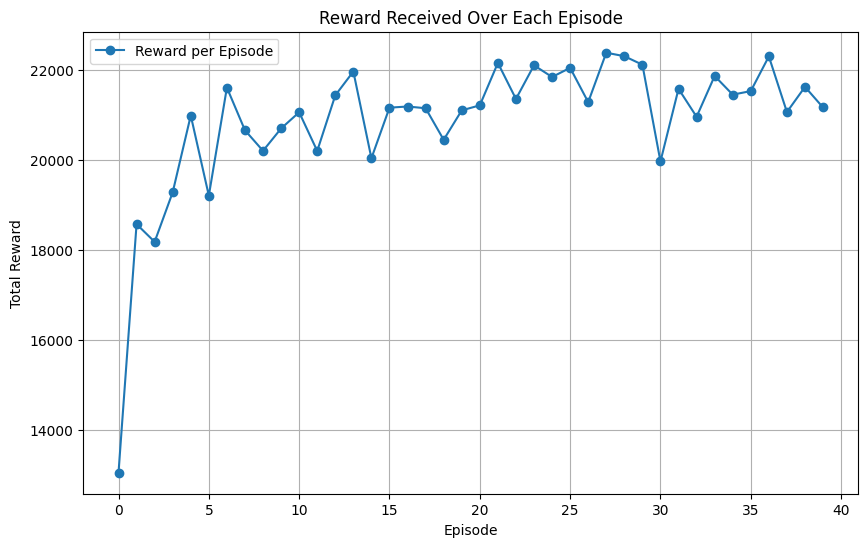

In [5]:

# Initialize the environment and strategy
env = pricing_env.PricingEnvironment(render_mode="text", is_continuous=False, product_config=product_config, demand_calculator_config=demand_calculator_config, action_strategy_config=action_strategy_config)

strategy = action_strategy.ActionStrategy(action_strategy_config['action_probabilities'],epsilon=0.1)
num_episodes = 40
max_steps_per_episode = 250
episode_rewards = []

for episode in range(num_episodes):
    initial_state = env.reset()
    total_reward = 0

    for step in range(max_steps_per_episode):
        action = strategy.choose_action()
        external_demand = np.random.uniform(0.5, 1.5)  # Simulate external market demand
        state, reward, done, _ = env.step(action, external_demand)
        strategy.update_probabilities(action, reward)  # Update the strategy based on the reward
        
        total_reward += reward
        if done:
            break

    #print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    episode_rewards.append(total_reward)

# Visualization after completing all episodes
visualise_episode_rewards(episode_rewards)



### Q Learning Agent 

In [6]:
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_rate=0.95,
                 exploration_rate=1.0, exploration_decay=0.99, min_exploration_rate=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.q_table = np.zeros((state_size, action_size))
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate

    def act(self, state):
        # Exploration-exploitation trade-off
        if np.random.rand() < self.exploration_rate:
            return np.random.choice(range(self.action_size))
        return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state, done):
        # Update Q-value using the Bellman equation
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_rate * self.q_table[next_state][best_next_action] * (not done)
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error
        # Decay exploration rate
        if done:
            self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)


In [10]:
### Ürüne olan demande göre state definition yapılmalı

def encode_state(market_demand, num_bins=10, max_market_demand=1.5):
    """
    Encodes the market demand into a discrete state based on the ratio of 
    market_demand to the maximum market demand.

    Args:
        market_demand (float): The current market demand from the environment's state.
        num_bins (int): The number of bins to discretize the demand ratio into.
        max_market_demand (float): The maximum possible market demand to normalize the ratio.

    Returns:
        int: A discrete integer representing the encoded state.
    """
    # Normalize market demand
    normalized_demand = market_demand / max_market_demand
    
    # Discretize the normalized demand
    discrete_state = int(max_market_demand * num_bins)
    # Ensure the discrete state is within the bounds [0, num_bins-1]
    discrete_state = min(max(discrete_state, 0), num_bins - 1)
    
    return discrete_state


Episode 1: Total Reward = 9488.617238952937
Episode 2: Total Reward = 7549.685958089155
Episode 3: Total Reward = 7665.588762137144
Episode 4: Total Reward = 9362.722836528026
Episode 5: Total Reward = 7528.502759980751
Episode 6: Total Reward = 14403.26829492596
Episode 7: Total Reward = 10388.98731143834
Episode 8: Total Reward = 14234.093458387148
Episode 9: Total Reward = 11835.54734898578
Episode 10: Total Reward = 16586.84855380932
Episode 11: Total Reward = 13143.15223857686
Episode 12: Total Reward = 14159.08231226265
Episode 13: Total Reward = 15205.024599904658
Episode 14: Total Reward = 18514.05103056258
Episode 15: Total Reward = 13420.696711153354
Episode 16: Total Reward = 17030.237187175248
Episode 17: Total Reward = 16318.76711583584
Episode 18: Total Reward = 14348.199116582879
Episode 19: Total Reward = 17713.030228078136
Episode 20: Total Reward = 17838.749890306823
Episode 21: Total Reward = 18483.87949015622
Episode 22: Total Reward = 14257.64800409167
Episode 23: 

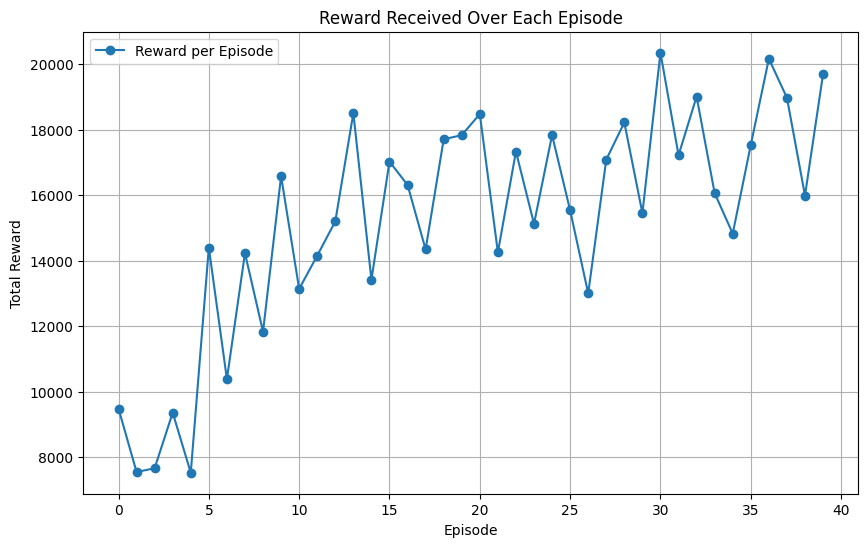

In [8]:

# Initialize the environment with the configs
env = pricing_env.PricingEnvironment(render_mode="text", is_continuous=False, product_config=product_config, demand_calculator_config=demand_calculator_config, action_strategy_config=action_strategy_config)

# Initialize the Q-learning agent
# Assuming state_size is determined by your environment's specifics
agent = QLearningAgent(state_size=15, action_size=5)
num_bins = 15  # Define the granularity of your discretization
state_bounds = [(env.min_price, env.max_price)]

num_episodes = 40
max_steps_per_episode = 250

episode_rewards = []
for episode in range(num_episodes):
    initial_state = env.reset()
    market_demand = initial_state[0]  # Extract market demand from the state
    state = encode_state(market_demand, num_bins=num_bins)  # Encode the initial state
    
    total_reward = 0
    
    for step in range(max_steps_per_episode):
        action = agent.act(state)
        next_state_info, reward, done, _ = env.step(action, external_demand_function())  # Simulate action and external demand
        next_market_demand = next_state_info[0]  # Extract market demand from the next state TODO 
        next_state = encode_state(next_market_demand, num_bins=num_bins)  # Encode the next state

        agent.update(state, action, reward, next_state, done)
        
        state = next_state
        total_reward += reward
        

        if done:
            break
 
    agent.exploration_rate = max(agent.min_exploration_rate, agent.exploration_rate * agent.exploration_decay)
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
        

    episode_rewards.append(total_reward)   

# Visualization after completing all episodes
visualise_episode_rewards(episode_rewards)


In [12]:
def encode_state_2(market_demand, boundaries):
    """
    Encodes the market demand into a discrete state based on specified boundaries.

    Args:
        market_demand (float): The current market demand from the environment's state.
        boundaries (list of floats): The boundaries between different demand bins. Should be sorted in ascending order.

    Returns:
        int: A discrete integer representing the encoded state. Returns the index of the bin into which the market demand falls.
    """
    # Iterate over the boundaries to determine the correct bin
    for i, boundary in enumerate(boundaries):
        if market_demand < boundary:
            return i
    # If the demand is greater than all boundaries, return the last bin index
    return len(boundaries)

# Example usage
boundaries = [0.3, 0.6, 0.9, 1.2]  # Define boundaries for market demand bins
market_demand = 0.75  # Current market demand

# Encode the current market demand
state = encode_state_2(market_demand, boundaries)
print("Encoded state:", state)


Encoded state: 2


Episode 1: Total Reward = 12294.472789118938
Episode 2: Total Reward = 10231.18867948908
Episode 3: Total Reward = 9458.387641576122
Episode 4: Total Reward = 7016.985505125288
Episode 5: Total Reward = 6739.244200591281
Episode 6: Total Reward = 11061.847358352046
Episode 7: Total Reward = 9299.360129859933
Episode 8: Total Reward = 12869.211180726708
Episode 9: Total Reward = 8793.477859842606
Episode 10: Total Reward = 13574.102281221853
Episode 11: Total Reward = 14213.352002121197
Episode 12: Total Reward = 11251.303513966568
Episode 13: Total Reward = 13371.51748289189
Episode 14: Total Reward = 11941.422824789463
Episode 15: Total Reward = 14263.553550339398
Episode 16: Total Reward = 14082.199615276706
Episode 17: Total Reward = 16137.567653267866
Episode 18: Total Reward = 14801.354978658776
Episode 19: Total Reward = 17295.43841495034
Episode 20: Total Reward = 15801.893536661713
Episode 21: Total Reward = 17149.78662764525
Episode 22: Total Reward = 14871.792763739251
Episod

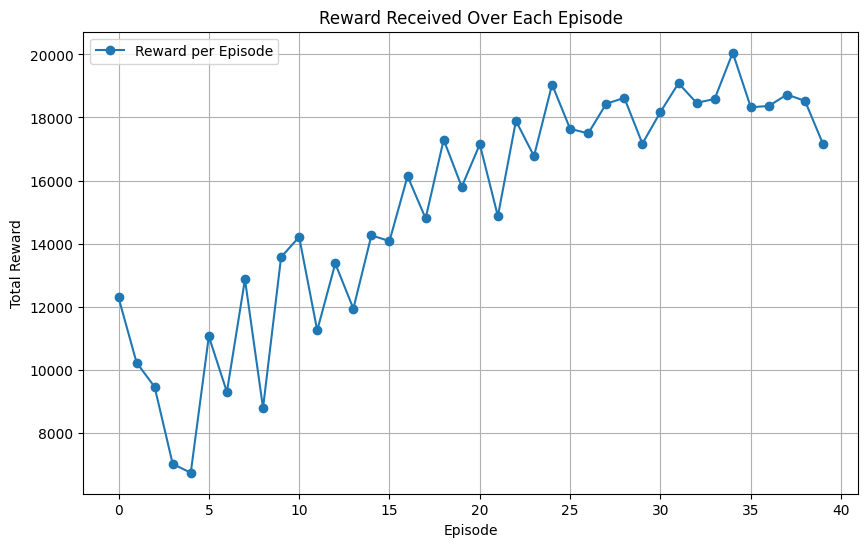

In [14]:
# Define boundaries based on expected ranges of market demand
# For example, if market demands typically range from 0 to 1.5, you might define:
boundaries = [0.3, 0.6, 0.9, 1.2, 1.5]

# Assuming state_size should now correspond to the number of bins derived from the boundaries
state_size = len(boundaries) + 1  # plus one for demands above the highest boundary

# Initialize the Q-learning agent with the updated state size
agent = QLearningAgent(state_size=state_size, action_size=5)

# Simulation loop adjusted for new encode_state usage
num_episodes = 40
max_steps_per_episode = 250
episode_rewards = []

for episode in range(num_episodes):
    initial_state = env.reset()
    market_demand = initial_state[0]  # Extract market demand from the state
    state = encode_state_2(market_demand, boundaries)  # Encode the initial state using new boundaries
    
    total_reward = 0
    
    for step in range(max_steps_per_episode):
        action = agent.act(state)
        next_state_info, reward, done, _ = env.step(action, external_demand_function())  # Simulate action and external demand
        next_market_demand = next_state_info[0]  # Extract market demand from the next state
        next_state = encode_state_2(next_market_demand, boundaries)  # Encode the next state using new boundaries

        agent.update(state, action, reward, next_state, done)
        
        state = next_state
        total_reward += reward
        
        if done:
            break

    agent.exploration_rate = max(agent.min_exploration_rate, agent.exploration_rate * agent.exploration_decay)
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    episode_rewards.append(total_reward)

# Visualization after completing all episodes
visualise_episode_rewards(episode_rewards)


### Upper Confidence Bound

In [15]:
action_prices = {
    0: 70,  # Price option 1
    1: 80,  # Price option 2
    2: 90, # Price option 3
    3: 95, # Price option 4
    4: 100  # Price option 5
}

# Example of a more granular action_prices for "continuous" prices
#action_prices = {i: price for i, price in enumerate(range(70, 101, 5))}  # Prices from 70 to 100 in steps of 5


class UCB:
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.action_counts = np.zeros(n_actions, dtype=int)
        self.total_rewards = np.zeros(n_actions, dtype=float)
        
    def select_action(self):
        for action in range(self.n_actions):
            if self.action_counts[action] == 0:
                return action
        ucb_values = self.total_rewards / self.action_counts + np.sqrt(2 * np.log(sum(self.action_counts)) / self.action_counts)
        return np.argmax(ucb_values)
    
    def update(self, action, reward):
        self.action_counts[action] += 1
        self.total_rewards[action] += reward


# Adjusted to map actions directly to specific prices


In [16]:
action_prices

{0: 70, 1: 80, 2: 90, 3: 95, 4: 100}

In [17]:
class UCB:
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.action_counts = np.zeros(n_actions, dtype=int)
        self.total_rewards = np.zeros(n_actions, dtype=float)
    
    def select_action(self):
        for action in range(self.n_actions):
            if self.action_counts[action] == 0:
                return action
        ucb_values = self.total_rewards / self.action_counts + np.sqrt(2 * np.log(sum(self.action_counts)) / self.action_counts)
        return np.argmax(ucb_values)
    
    def update(self, action, reward):
        self.action_counts[action] += 1
        self.total_rewards[action] += reward

# Action price change map
price_change_map = {
    0: -10,  # Decrease significantly
    1: -5,   # Decrease slightly
    2: 0,    # Keep price
    3: 5,    # Increase slightly
    4: 10    # Increase significantly
}

# Initialize UCB agent with the number of actions
ucb_agent = UCB(len(price_change_map))

# Assuming the environment is already imported and initialized
env = pricing_env.PricingEnvironment(render_mode="text", is_continuous=True, product_config=product_config, demand_calculator_config=demand_calculator_config, action_strategy_config=action_strategy_config)

prices_per_episode = []  # Store prices for each episode
market_demands_per_episode = []  # Store market demands for each episode
captured_demands_per_episode = []  # Store captured demands for each episode
episode_rewards = []
num_episodes = 10
max_steps_per_episode = 250

for episode in range(num_episodes):
    total_reward = 0
    episode_prices = [env.current_price]  # Start with the initial price
    episode_market_demands = []
    episode_captured_demands = []
    
    for step in range(max_steps_per_episode):
        action = ucb_agent.select_action()
        price_change = price_change_map[action]
        current_price = max(env.min_price, min(env.max_price, episode_prices[-1] + price_change))
        episode_prices.append(current_price)
        
        next_state_info, reward, done, _ = env.step(current_price, external_demand_function())
        ucb_agent.update(action, reward)
        
        market_demand = next_state_info[0]  # Example extraction of market demand
        captured_demand = env.current_demand  # Example extraction of captured demand
        
        episode_market_demands.append(market_demand)
        episode_captured_demands.append(captured_demand)
        
        total_reward += reward
        if done:
            break
    
    prices_per_episode.append(episode_prices)
    market_demands_per_episode.append(episode_market_demands)
    captured_demands_per_episode.append(episode_captured_demands)
    episode_rewards.append(total_reward)

# Assuming visualisation functions are defined to plot these details




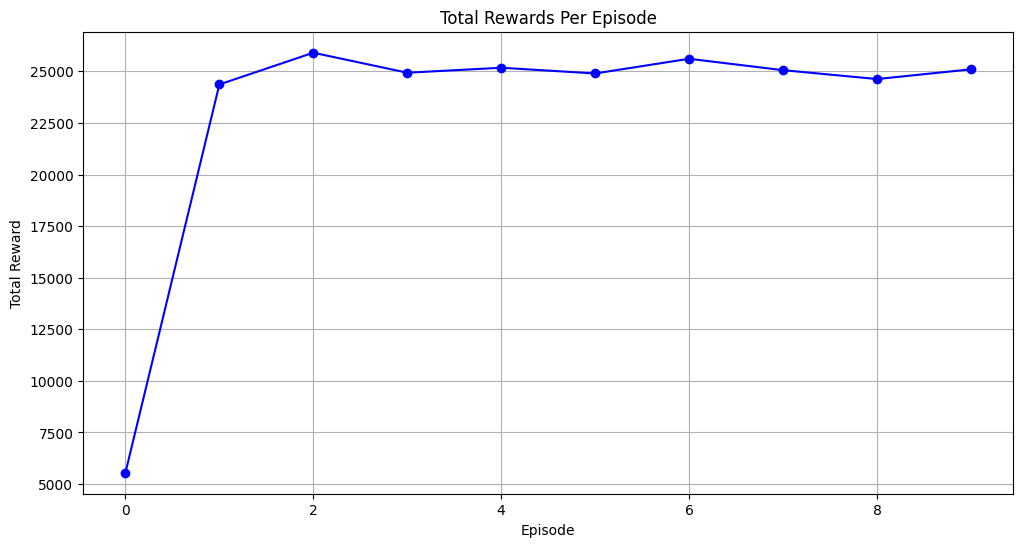

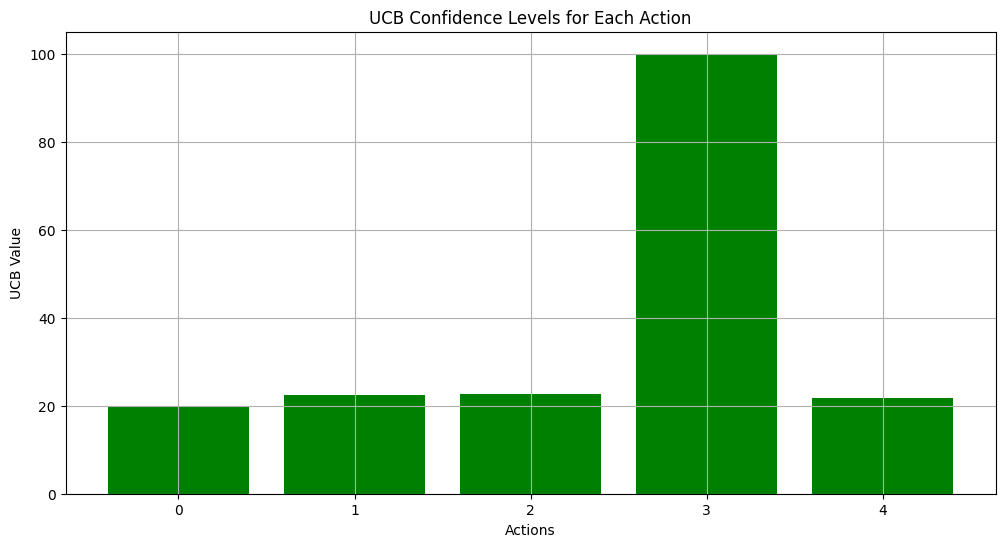

In [19]:

def visualise_total_rewards_ucb(episode_rewards):
    """
    Visualizes the total rewards received in each episode.

    Args:
        episode_rewards (list): List of total rewards per episode.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards, marker='o', linestyle='-', color='b')
    plt.title('Total Rewards Per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

def visualise_ucb_confidence(ucb_agent):
    """
    Visualizes the UCB confidence levels for each action.

    Args:
        ucb_agent (UCB): The UCB agent instance after simulation.
    """
    # Calculate the UCB values one final time
    if sum(ucb_agent.action_counts) == 0:
        return  # Avoid division by zero if no actions were taken
    ucb_values = ucb_agent.total_rewards / ucb_agent.action_counts + \
                 np.sqrt(2 * np.log(sum(ucb_agent.action_counts)) / ucb_agent.action_counts)
    
    plt.figure(figsize=(12, 6))
    actions = range(len(ucb_values))
    plt.bar(actions, ucb_values, color='green')
    plt.title('UCB Confidence Levels for Each Action')
    plt.xlabel('Actions')
    plt.ylabel('UCB Value')
    plt.xticks(actions)  # Ensure that each action is labeled with its index
    plt.grid(True)
    plt.show()

# Assume episode_rewards and ucb_agent are defined from your UCB simulation run
visualise_total_rewards_ucb(episode_rewards)
visualise_ucb_confidence(ucb_agent)


### Soft Actor Critic Agent

In [5]:
import gymnasium
import numpy as np
from gymnasium import spaces
import matplotlib.pyplot as plt
from utils import visualise_pricing_strategy, visualise_episode_rewards,visualise_demand_data, external_demand_function
from Pricing_Environment import demand_calculator, action_strategy,pricing_env

import random
random.seed(42)
np.random.seed(42)

product_config = {
    "min_price": 10,
    "max_price": 100,
    "initial_demand": 0.5,
}

demand_calculator_config = {
    "price_probability_ranges": {
        (0, 50): 0.8,   # 80% demand probability for prices between $0 and $50
        (51, 100): 0.6, # 60% demand probability for prices between $51 and $100
        # Add more ranges a
        # nd probabilities as needed
    },
    'low':0,
    'high':100,
    'seasonality':True
}

action_strategy_config = {
    "action_probabilities": {
        0: 0.1,  # Decrease price significantly
        1: 0.2,  # Decrease price slightly
        2: 0.4,  # Keep price
        3: 0.2,  # Increase price slightly
        4: 0.1,  # Increase price significantly
    },
    "price_change_map": {
        0: -10,  # Decrease significantly
        1: -5,   # Decrease slightly
        2: 0,    # Keep price
        3: 5,    # Increase slightly
        4: 10    # Increase significantly
    }
}



In [6]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'


In [7]:
import torch

# Check if CUDA (GPU support) is available and choose accordingly
device = torch.device("cpu")


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal


In [8]:


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.mean = nn.Linear(256, action_dim)
        self.log_std = nn.Linear(256, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        std = torch.exp(log_std)  # Standard deviation must be positive
        return mean, std

    def sample(self, state):
        mean, std = self(state)
        normal = torch.distributions.Normal(mean, std)
        z = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        action = torch.tanh(z) * self.max_action
        return action

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, state, action):
        sa = torch.cat([state, action], 1)
        return self.network(sa)

class SACAgent:
    def __init__(self, state_dim, action_dim, max_action, device):
        self.device = device
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.critic1 = Critic(state_dim, action_dim).to(device)
        self.critic2 = Critic(state_dim, action_dim).to(device)
        self.critic1_target = Critic(state_dim, action_dim).to(device)
        self.critic2_target = Critic(state_dim, action_dim).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=3e-4)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=3e-4)
        self.discount = 0.99
        self.tau = 0.005
        self.policy_delay = 2

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
        action = self.actor.sample(state)
        return action.cpu().data.numpy().flatten()

    def save_model(self, filename):
        torch.save({
            'actor_state_dict': self.actor.state_dict(),
            'critic1_state_dict': self.critic1.state_dict(),
            'critic2_state_dict': self.critic2.state_dict(),
            'critic1_target_state_dict': self.critic1_target.state_dict(),
            'critic2_target_state_dict': self.critic2_target.state_dict(),
            'actor_optimizer_state_dict': self.actor_optimizer.state_dict(),
            'critic1_optimizer_state_dict': self.critic1_optimizer.state_dict(),
            'critic2_optimizer_state_dict': self.critic2_optimizer.state_dict(),
        }, filename)

    def load_model(self, filename):
        checkpoint = torch.load(filename)
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.critic1.load_state_dict(checkpoint['critic1_state_dict'])
        self.critic2.load_state_dict(checkpoint['critic2_state_dict'])
        self.critic1_target.load_state_dict(checkpoint['critic1_target_state_dict'])
        self.critic2_target.load_state_dict(checkpoint['critic2_target_state_dict'])
        self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer_state_dict'])
        self.critic1_optimizer.load_state_dict(checkpoint['critic1_optimizer_state_dict'])
        self.critic2_optimizer.load_state_dict(checkpoint['critic2_optimizer_state_dict'])
        self.actor.to(self.device)
        self.critic1.to(self.device)
        self.critic2.to(self.device)
        self.critic1_target.to(self.device)
        self.critic2_target.to(self.device)

    def train(self, replay_buffer, batch_size=256):
        for it in range(batch_size):
            # Sample a batch of transitions from the replay buffer
            state, action, next_state, reward, done = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(self.device)
            action = torch.FloatTensor(action).to(self.device)
            next_state = torch.FloatTensor(next_state).to(self.device)
            reward = torch.FloatTensor(reward).to(self.device)
            done = torch.FloatTensor(done).to(self.device)

            # Compute the target Q value
            with torch.no_grad():
                next_action = self.actor.sample(next_state)
                target_Q1 = self.critic1_target(next_state, next_action)
                target_Q2 = self.critic2_target(next_state, next_action)
                target_Q = torch.min(target_Q1, target_Q2)
                target_Q = reward + ((1 - done) * self.discount * target_Q)

            # Get current Q estimates
            current_Q1 = self.critic1(state, action)
            current_Q2 = self.critic2(state, action)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            # Optimize the critic
            self.critic1_optimizer.zero_grad()
            self.critic2_optimizer.zero_grad()
            critic_loss.backward()
            self.critic1_optimizer.step()
            self.critic2_optimizer.step()

            # Delayed policy updates
            if it % self.policy_delay == 0:
                # Compute actor loss
                actor_loss = -self.critic1(state, self.actor.sample(state)).mean()

                # Optimize the actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Soft update the target networks
                for param, target_param in zip(self.critic1.parameters(), self.critic1_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

                for param, target_param in zip(self.critic2.parameters(), self.critic2_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


In [9]:
# Assuming the environment is already imported and initialized
env = pricing_env.PricingEnvironment(render_mode="text", is_continuous=True, product_config=product_config, demand_calculator_config=demand_calculator_config, action_strategy_config=action_strategy_config)


In [10]:

# Initialize the SAC Agent
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] if env.is_continuous else env.action_space.n
max_action = env.action_space.high[0] if env.is_continuous else 1


In [12]:
agent = SACAgent(state_dim, action_dim, max_action, device)

In [13]:
agent.load_model('sac_agent.pth')

In [15]:
max_steps_per_episode = 250 
demand_generator = pricing_env.DemandDataGenerator(
    low=demand_calculator_config['low'],
    high=demand_calculator_config['high'],
    steps=max_steps_per_episode,
    seasonality=True
)

demand_generator.generate()[4 % demand_generator.steps]

21.00763407005068

Current Demand: 9.0, Type: <class 'numpy.float64'>
Current Price: 96.70134735107422, Type: <class 'numpy.float64'>
Current Demand: 15.252309981426244, Type: <class 'numpy.float64'>
Current Price: 100.0, Type: <class 'numpy.float64'>
Current Demand: 7.504459315922787, Type: <class 'numpy.float64'>
Current Price: 100.0, Type: <class 'numpy.float64'>
Current Demand: 25.05377247530674, Type: <class 'numpy.float64'>
Current Price: 95.84813690185547, Type: <class 'numpy.float64'>
Current Demand: 54.007634070050685, Type: <class 'numpy.float64'>
Current Price: 100.0, Type: <class 'numpy.float64'>
Current Demand: 19.406671292794957, Type: <class 'numpy.float64'>
Current Price: 10.0, Type: <class 'numpy.float64'>
Current Demand: 29.104945782968244, Type: <class 'numpy.float64'>
Current Price: 91.37626647949219, Type: <class 'numpy.float64'>
Current Demand: 16.60574921757801, Type: <class 'numpy.float64'>
Current Price: 10.0, Type: <class 'numpy.float64'>
Current Demand: 54.603006758137504, Type

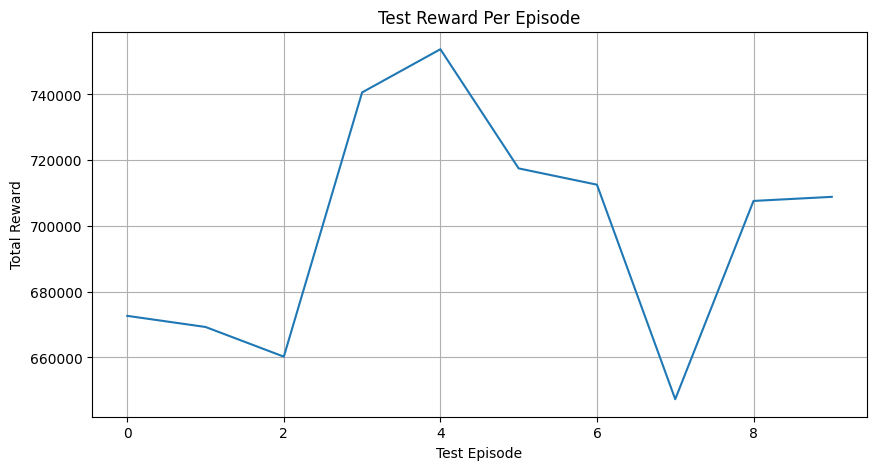

In [16]:
# Test the loaded agent
num_test_episodes = 10
test_rewards = []
max_steps_per_episode=250


for episode in range(num_test_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    step = 0

    while not done and step < max_steps_per_episode:
        action = agent.select_action(state)  # Select action without exploration
        demand = demand_generator.generate()[step % demand_generator.steps]
        next_state, reward, done, _ = env.step(action, demand)
        total_reward += reward
        state = next_state
        step += 1

    test_rewards.append(total_reward)
    print(f"Test Episode {episode}: Total Reward = {total_reward}")

# Optionally, plot the test rewards
plt.figure(figsize=(10, 5))
plt.plot(test_rewards)
plt.xlabel("Test Episode")
plt.ylabel("Total Reward")
plt.title("Test Reward Per Episode")
plt.grid(True)
plt.show()


In [18]:
agent.actor.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 7.1278e-02, -1.2746e-01],
                      [ 6.4747e-01, -6.2259e-01],
                      [-5.7356e-01,  7.3479e-02],
                      [ 1.8529e-01, -6.8886e-01],
                      [ 5.5104e-01,  2.1881e-01],
                      [-1.5089e-01, -6.2184e-01],
                      [-5.0598e-01, -5.3441e-01],
                      [ 4.3275e-01,  2.8144e-01],
                      [ 2.7233e-01,  5.9100e-01],
                      [-2.0790e-02, -4.4258e-01],
                      [-4.1135e-01, -5.8648e-01],
                      [ 1.0394e-01, -6.8362e-01],
                      [-1.0105e-01,  6.0400e-01],
                      [ 1.6376e-01, -9.7533e-02],
                      [ 6.7984e-03, -2.5708e-01],
                      [ 4.0500e-01, -3.1925e-01],
                      [-2.5767e-01,  3.9309e-01],
                      [-6.3977e-01,  6.9111e-01],
                      [-9.5234e-02,  2.8071e-01],
                      

In [10]:
'''
class SACAgent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.critic1 = Critic(state_dim, action_dim).to(device)
        self.critic2 = Critic(state_dim, action_dim).to(device)
        self.critic1_target = Critic(state_dim, action_dim).to(device)
        self.critic2_target = Critic(state_dim, action_dim).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=3e-4)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=3e-4)

# Assuming Actor and Critic are defined correctly, and the state_dim, action_dim, max_action are set appropriately
sac_agent = SACAgent(state_dim=3, action_dim=1, max_action=1)

# Test a simple forward pass
test_state = torch.randn(1, 3)
action = sac_agent.actor(test_state)  # Depending on how Actor is defined, you might need to modify this call
print("Action:", action)


# Test a simple forward pass
test_state = torch.randn(1, 3)
action = sac_agent.actor(test_state)  # Depending on how Actor is defined, you might need to modify this call
print("Action:", action)
'''

'\nclass SACAgent:\n    def __init__(self, state_dim, action_dim, max_action):\n        self.actor = Actor(state_dim, action_dim, max_action).to(device)\n        self.critic1 = Critic(state_dim, action_dim).to(device)\n        self.critic2 = Critic(state_dim, action_dim).to(device)\n        self.critic1_target = Critic(state_dim, action_dim).to(device)\n        self.critic2_target = Critic(state_dim, action_dim).to(device)\n        self.critic1_target.load_state_dict(self.critic1.state_dict())\n        self.critic2_target.load_state_dict(self.critic2.state_dict())\n\n        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)\n        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=3e-4)\n        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=3e-4)\n\n# Assuming Actor and Critic are defined correctly, and the state_dim, action_dim, max_action are set appropriately\nsac_agent = SACAgent(state_dim=3, action_dim=1, max_action=1)\n\n# Te

In [12]:
sac_agent = SACAgent(state_dim=3, action_dim=1, max_action=1,device=device)

In [13]:


# Test a simple forward pass
test_state = torch.randn(1, 3)
action = sac_agent.actor(test_state)  # Depending on how Actor is defined, you might need to modify this call
print("Action:", action)



Action: (tensor([[0.0348]], grad_fn=<AddmmBackward0>), tensor([[1.1814]], grad_fn=<ExpBackward0>))


In [15]:
agent = SACAgent(state_dim=state_dim, action_dim=action_dim, max_action=max_action,device=device)


In [16]:
agent.critic1_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

In [1]:


# Simulation setup
num_episodes = 100
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action,external_demand_function())
        total_reward += reward
        # Assume the replay buffer and training function are handled here
        state = next_state
    episode_rewards.append(total_reward)
    print(f"Episode {episode}: Total Reward: {total_reward}")

# Plot the rewards
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Per Episode - SAC")
plt.show()


NameError: name 'env' is not defined

In [31]:
action

array([-87.62424], dtype=float32)

In [32]:
env.step(action,external_market_demand=external_demand_function())

Current Demand: 1.0659541126403373, Type: <class 'float'>
Current Price: [10.], Type: <class 'numpy.ndarray'>


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [23]:
# Initialize the Pricing Environment


# Initialize the SAC Agent
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] if env.is_continuous else env.action_space.n
max_action = env.action_space.high[0] if env.is_continuous else 1

agent = SACAgent(state_dim, action_dim, max_action)

# Simulation setup
num_episodes = 100
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action,external_market_demand=np.random.uniform(0.5, 1.5))
        total_reward += reward
        # Assume the replay buffer and training function are handled here
        state = next_state
    episode_rewards.append(total_reward)
    print(f"Episode {episode}: Total Reward: {total_reward}")

# Plot the rewards
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward Per Episode - SAC")
plt.show()


Current Demand: 0.5248149123539493, Type: <class 'float'>
Current Price: [10.], Type: <class 'numpy.ndarray'>


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.